In [1]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np



In [16]:
def format_print_str(long_str, line_length=175):
    formatted_str = '\n'.join([long_str[i:i+line_length] for i in range(0, len(long_str), line_length)])
    return formatted_str

def calculate_iou(box1, box2):
    """
    计算两个边界框的 IoU
    :param box1: 第一个边界框，格式为 (x1, y1, x2, y2)
    :param box2: 第二个边界框，格式为 (x1, y1, x2, y2)
    :return: IoU 值
    """
    # 获取两个边界框的坐标
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # 计算交集的坐标
    x1_inter = max(x1_1, x1_2)
    y1_inter = max(y1_1, y1_2)
    x2_inter = min(x2_1, x2_2)
    y2_inter = min(y2_1, y2_2)

    # 计算交集的面积
    if x2_inter > x1_inter and y2_inter > y1_inter:
        area_inter = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        area_inter = 0

    # 计算两个边界框的面积
    area_box1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area_box2 = (x2_2 - x1_2) * (y2_2 - y1_2)

    # 计算并集的面积
    area_union = area_box1 + area_box2 - area_inter

    # 计算 IoU
    if area_union == 0:
        return 0
    iou = area_inter / area_union
    return iou

def print_content(content):
    lines = content.splitlines()
    for line in lines:
        print(format_print_str(line))


def show_thinking(ori_image, conversation, ori_gt_boxes):
    for idx, conv in enumerate(conversation):
        conv_role = conv['role']
        content = conv['content']
        if conv_role == 'system':
            continue
        elif idx == 1:
            for _content in content:
                if _content['type'] == 'text':
                    _content = _content['text']
                    _content = _content.split('\n')[0]
                    print ("USER:   ")
                    print_content(_content + '\n\n')
        elif conv_role == 'assistant':
            if isinstance(content, str):
                _content = content
            elif isinstance(content, list):
                for _content in content:
                    if _content['type'] == 'text':
                        _content = _content['text']
            else:
                continue
            print ("ASSISTANT:   ")
            print_content(_content)
            # if "```json" in _content:
            #     _bbox_str = _content.split("```json")[1].split("```")[0]
            if "<tool_call>" in _content:
                _bbox_str = _content.split("<tool_call>")[1].split("</tool_call>")[0].strip()
                _bbox = [eval(_bbox_str)]
                for _box in _bbox:
                    _box = _box['arguments']['bbox_2d']
                    x1, y1, x2, y2 = _box
                    _crop_img = ori_image.crop((x1, y1, x2, y2))
                    max_iou = 0.
                    for _gt_box in ori_gt_boxes:
                        _gt_x1, gt_y1, gt_w, gt_h = _gt_box
                        _gt_x2, gt_y2 = _gt_x1 + gt_w, gt_y1 + gt_h
                        _gt_box = (_gt_x1, gt_y1, _gt_x2, gt_y2)
                        iou = calculate_iou(_box, _gt_box)
                        if iou > max_iou:
                            max_iou = iou
                    print ('IOU: ', max_iou)
                    print ('Area Size: ', _box[2] - _box[0], _box[3] - _box[1], (_box[2] - _box[0]) * (_box[3] - _box[1]), 4*28*28)

                    plt.imshow(_crop_img)
                    plt.axis('off')
                    plt.show()
            print_content('\n\n')
        else:
            if isinstance(content, str):
                _content = content
            elif isinstance(content, list):
                for _content in content:
                    if _content['type'] == 'text':
                        _content = _content['text']
            else:
                continue
            
            print ("USER:   ")
            print_content(_content + '\n\n')


        


In [36]:
root_path = '/cpfs/user/honglingyi/DATA/LLM/Vstar/vstar_bench'
json_path = '/cpfs/user/zhengziwei/workspace/agent/VeRL-Agent/eval_results/vlagent_think_mh/multiturn_all21k_0.8acc_-0.2format_0.4tool_4node_ds4/global_step_40/result_relative_position.jsonl'

if 'direct_attributes' in json_path:
    root_path = os.path.join(root_path, 'direct_attributes')
else:
    root_path = os.path.join(root_path, 'relative_position')


In [37]:
with open(json_path, 'r') as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]
line_map = {}
image_list = []
for line in lines:
    line_map[line['image']] = line
    image_list.append(line['image'])

In [5]:
error_list = []
for idx, image in enumerate(image_list):
    acc = line_map[image]['acc']
    if acc == 0:
        error_list.append(idx)
        
print ('Error List: ', error_list)

KeyError: 'acc'

In [47]:
line_id = 3
tosee_img = image_list[line_id]
# tosee_img = "sa_25219.jpg"
img_path = os.path.join(root_path, tosee_img)
question = line_map[tosee_img]['question']
answer = line_map[tosee_img]['answer']
pred_ans = line_map[tosee_img]['pred_ans']
pred_output = line_map[tosee_img]['pred_output']
# acc = line_map[tosee_img]['acc']
print ('image: ', tosee_img)
print (f"question: {question}")
print (f"answer: {answer}")
print (f"pred_ans: {pred_ans}")
# print (f"acc: {acc}")

image:  sa_5593.jpg
question: Is the orange luggage on the left or right side of the purple umbrella?
answer: The orange luggage is on the right side of the purple umbrella.
pred_ans: The orange luggage is on the right side of the purple umbrella.


image:  sa_5593.jpg
question: Is the orange luggage on the left or right side of the purple umbrella?
answer: The orange luggage is on the right side of the purple umbrella.
pred_ans: The orange luggage is on the right side of the purple umbrella.
orange luggage
[1347, 1303, 1393, 1432]
purple umbrella
[164, 1199, 267, 1243]


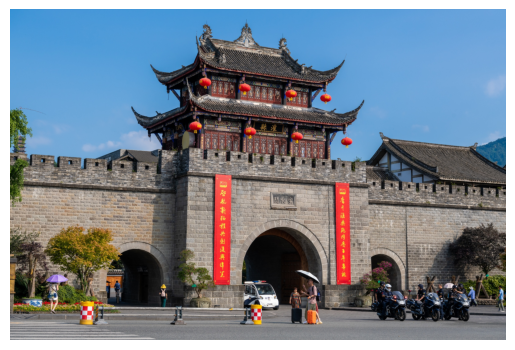

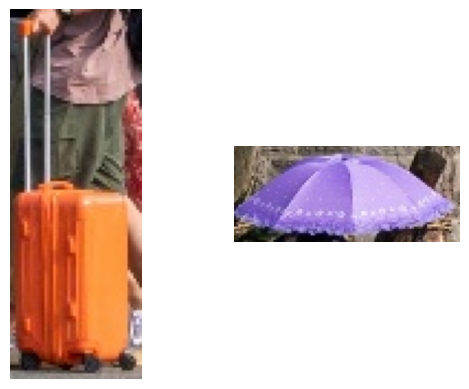

In [48]:
ori_image_path = os.path.join(root_path, tosee_img)
ori_json_path = os.path.join(root_path, tosee_img.replace('.jpg', '.json'))
ori_json = json.load(open(ori_json_path, 'r'))
ori_gt_name = ori_json['target_object']
ori_gt_boxes = ori_json['bbox']

box_color = (255, 0, 0)  # 红色
border_width = 2

print ('image: ', tosee_img)
print (f"question: {question}")
print (f"answer: {answer}")
print (f"pred_ans: {pred_ans}")
# print (f"acc: {acc}")

ori_image = Image.open(ori_image_path)
draw = ImageDraw.Draw(ori_image)
crop_imgs = []
for idx, _box in enumerate(ori_gt_boxes):
    _box = [_box[0], _box[1], _box[2] + _box[0], _box[3] + _box[1]]
    print (f"{ori_gt_name[idx]}")
    print (_box)
    x1, y1, x2, y2 = _box
    # draw.rectangle((x1, y1, x2, y2), outline=box_color, width=border_width)
    _crop_img = ori_image.crop((x1, y1, x2, y2))
    crop_imgs.append(_crop_img)

plt.imshow(ori_image)
plt.axis('off')
plt.show()

for i, _crop_img in enumerate(crop_imgs):
    plt.subplot(1, len(crop_imgs), i + 1)
    plt.imshow(_crop_img)
    plt.axis('off')


USER:   
Question: Is the orange luggage on the left or right side of the purple umbrella?

ASSISTANT:   
<think>
To determine the position of the orange luggage relative to the purple umbrella, I need to zoom in on the area near the umbrella to get a clearer view of the luggage. This wil
l help me accurately identify the position of the luggage in relation to the umbrella.
</think>  
<tool_call>
{"name": "image_zoom_in_tool", "arguments": {"bbox_2d": [126, 1235, 300, 1400], "label": "purple umbrella"}}
IOU:  0.02541797766672836
Area Size:  174 165 28710 3136


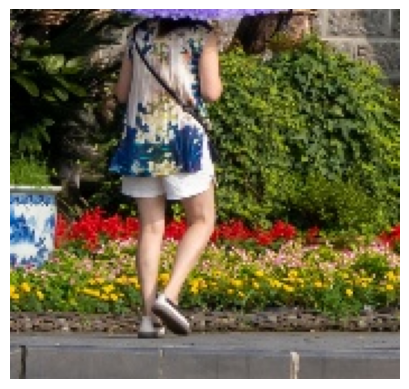



USER:   

Think first, call **image_zoom_in_tool** if needed, then answer. Format strictly as:  <think>...</think>  <tool_call>...</tool_call> (if tools needed)  <answer>...</answer> 

ASSISTANT:   
<think>
Based on the previous steps, it seems we have already determined the position of the orange luggage relative to the purple umbrella. The orange luggage is on the right side of
 the purple umbrella. Therefore, we can conclude the answer without needing to call the `image_zoom_in_tool` again.

The orange luggage is on the right side of the purple umbrella.
</think>  
 <answer>
The orange luggage is on the right side of the purple umbrella.
</answer>




In [49]:
show_thinking(ori_image, pred_output, ori_gt_boxes)